<a href="https://colab.research.google.com/github/emmanuel-olateju/EmotiSpot/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d khan1803115/eeg-dataset-for-emotion-recognition
!mkdir -p datasets/khan1803115
!unzip eeg-dataset-for-emotion-recognition.zip -d datasets/khan1803115/
!rm eeg-dataset-for-emotion-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/khan1803115/eeg-dataset-for-emotion-recognition
License(s): Apache 2.0
 98% 177M/181M [00:01<00:00, 116MB/s]
100% 181M/181M [00:01<00:00, 104MB/s]
Archive:  eeg-dataset-for-emotion-recognition.zip
  inflating: datasets/khan1803115/Data/S01G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G4AllChannels.csv  
  inflating: d

In [2]:
import os

import numpy as np
import pandas as pd
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.1 MB/s eta 0:00:00


In [3]:
import joblib
# from google.colab import files

def save_artifact(artifact,name):
  joblib.dump(artifact,name)
  # files.download(name)


## Data Loading

In [4]:
khan_dataset_dir = "datasets/khan1803115/"
valence = pd.read_csv(khan_dataset_dir+"valence_normalize.csv")
arousal = pd.read_csv(khan_dataset_dir+"arousal_normalize.csv")
data = [pd.read_csv(khan_dataset_dir+"Data/"+file) for file in os.listdir(khan_dataset_dir+"Data/")]

channels = data[0].columns[:-2]
label_columns = data[0].columns[-2:]
fs = 128

In [5]:
eeg_data = np.array([data_[channels][:38000] for data_ in data])
valence_arousal_values = np.array([data_[label_columns].mean() for data_ in data])
eeg_data.shape, valence_arousal_values.shape

((100, 38000, 14), (100, 2))

In [6]:
# Make use of 1250 samples for an epoch with 500 samples overlapping between succesive epochs
epoch_starting_points = np.arange(0,38252,1280-256)[:-4]

eeg_epochs = []

for i in range(len(data)):
    epochs = []
    for epoch_starting_point in epoch_starting_points:
        epochs.append(eeg_data[i,epoch_starting_point:epoch_starting_point+1280,:])

    eeg_epochs.append(epochs)

eeg_epochs = np.array(eeg_epochs)

eeg_epochs.shape

(100, 34, 1280, 14)

In [7]:
epoch_targets = []

for i in range(len(data)):
  targets = [valence_arousal_values[i]]*34
  epoch_targets.append(targets)

epoch_targets = np.array(epoch_targets)

epoch_targets.shape

(100, 34, 2)

In [8]:
eeg_epochs = eeg_epochs.reshape(3400,1280,14)
epoch_targets = epoch_targets.reshape(3400,2)

eeg_epochs.shape, epoch_targets.shape

((3400, 1280, 14), (3400, 2))

In [9]:
# save_artifact(eeg_epochs,"EEG_DATA.np")

## Preprocessing

In [10]:
lowcut = 1
highcut = 45

filtered_eeg_epochs = np.empty((3400,1280,14))

for e,epoch in enumerate(eeg_epochs):
  filtered = mne.filter.filter_data(epoch.T,fs,lowcut,highcut,verbose=0)
  filtered_eeg_epochs[e,:,:] = filtered.T

filtered_eeg_epochs.shape

(3400, 1280, 14)

In [11]:
# save_artifact(filtered_eeg_epochs,"FILTERED_EEG_DATA.np")
# save_artifact(epoch_targets,"EEG_VALENCE_AROUSAL_TARGETS.np")

## Make Dataloader

In [12]:
import random

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# Set the device
device_ = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device_}")

# Set the device globally
torch.set_default_device(device_)

random.seed(120)
torch.manual_seed(120)

Current Device: cpu


In [13]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, features, targets, transform=None):
    self.features = torch.tensor(features)
    self.targets = torch.tensor(targets)
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    feature = self.features[idx]
    target = self.targets[idx]
    if self.transform:
      feature = self.transform(feature)
    return feature, target

In [54]:
from sklearn.model_selection import train_test_split

X, y = filtered_eeg_epochs, epoch_targets

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=100)

print(f" Train Size :({X_train.shape}, {y_train.shape}) | Test Size : ({X_test.shape}, {y_test.shape}) | Validation Size: ({X_val.shape}, {y_val.shape})")

train_batch_size = 250
shuffle_ = True
num_workers_ = 5

# Make Train Dataloader
train_dataset = CustomDataset(X_train.astype(float),y_train.astype(float))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=shuffle_, num_workers=num_workers_, generator=torch.Generator(device=device_))

# Make Validation Dataloader
val_batch_size = 5
val_dataset = CustomDataset(X_val.astype(float),y_val.astype(float))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=shuffle_, num_workers=num_workers_, generator=torch.Generator(device=device_))

X_test = torch.tensor(X_test).to(torch.float)
y_test = torch.tensor(y_test).to(torch.float)

 Train Size :((2040, 1280, 14), (2040, 2)) | Test Size : ((680, 1280, 14), (680, 2)) | Validation Size: ((680, 1280, 14), (680, 2))


## Modelling

In [55]:
class mlp(nn.Module):

  def __init__(self):
    super(mlp,self).__init__()
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1280*14,1000),
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.Linear(1000,1000),
        nn.Sigmoid(),
        nn.Linear(1000,100),
        nn.Sigmoid(),
        nn.Linear(100,2),
        nn.Sigmoid(),
        nn.Linear(2,2),
        nn.ReLU()
    )


  def forward(self,x):
    x = x.view(x.size()[0],-1)
    x = self.fc1(x.to(torch.float32))
    return x

# class cnn(nn.Module):

#   def __init__(self):
#     super(cnn,self).__init__()


----------------------------------------------------------------------------------
Epoch: 0/100 | loss: 9.27 |  validation loss: 7.62
----------------------------------------------------------------------------------
Epoch: 1/100 | loss: 8.28 |  validation loss: 7.37
----------------------------------------------------------------------------------
Epoch: 2/100 | loss: 7.35 |  validation loss: 7.13
----------------------------------------------------------------------------------
Epoch: 3/100 | loss: 7.23 |  validation loss: 6.88
----------------------------------------------------------------------------------
Epoch: 4/100 | loss: 8.34 |  validation loss: 6.64
----------------------------------------------------------------------------------
Epoch: 5/100 | loss: 7.26 |  validation loss: 6.40
----------------------------------------------------------------------------------
Epoch: 6/100 | loss: 5.61 |  validation loss: 6.17
--------------------------------------------------------------

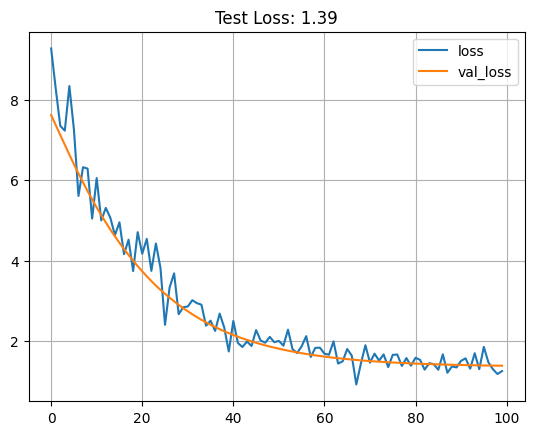

In [56]:
history = {
    "loss":[],
    "val_loss":[]
}

mlpn = mlp()

epochs = 100
lr_ = 0.001

optimizer = optim.SGD(mlpn.parameters(),lr=lr_)
loss_fn = nn.MSELoss()

train_loss, val_loss = [], []

for e in range(epochs):

  running_loss = 0.0
  val_running_loss = 0.0

  for batch, (x_,y_) in enumerate(train_dataloader):

    x_ = x_.to(torch.float)
    y_ = y_.to(torch.float)

    mlpn =mlpn.train()

    optimizer.zero_grad()

    y_est = mlpn(x_)
    y_est = y_est.requires_grad_(True)

    loss = loss_fn(y_est,y_)

    loss.backward()
    optimizer.step()

  running_loss += loss.item()
  history["loss"].append(running_loss)

  x_val, y_val = val_dataset[:]
  x_val = x_val.to(torch.float)
  y_val = y_val.to(torch.float)

  mlpn = mlpn.eval()

  y_est = mlpn(x_val)

  loss = loss_fn(y_est,y_val)
  val_running_loss = loss.item()
  history["val_loss"].append(val_running_loss)

  print("----------------------------------------------------------------------------------")
  print(f"Epoch: {e}/{epochs} | loss: {running_loss:.2f} |  validation loss: {val_running_loss:.2f}")

mlpn = mlpn.eval()

y_ = mlpn(X_test)
y_test = y_test.requires_grad_(True)

loss = loss_fn(y_test,y_)
print("------------------------------------------------------------------------------------")
print(f"Test Loss: {loss.item():.2f}")
print("------------------------------------------------------------------------------------")

print("Loss")
print(" ")
import matplotlib.pyplot as plt

plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val_loss")

plt.title(f"Test Loss: {loss.item():.2f}")

plt.grid()
plt.legend()

